# Creating Watermarked Images

In [48]:
import os
import math
import random

import kagglehub
import numpy as np
import pandas as pd
from PIL import Image

# make the operations deterministic
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
def read_images_dataset(images_path):
    image_files = [
        f for f in os.listdir(images_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    image_data = []

    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)

        img = Image.open(image_path)

        image_data.append(
            {"image_name": image_file, "image_path": image_path, "image_size": img.size}
        )

    return pd.DataFrame(image_data)

## [The Oxford-IIIT Pet Dataset](https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset)

We need to resize the images if the Oxford-IIIT Pet dataset does not match the ones required for the image classifier. We plan to use either Tiny-Vit 5M or MobileViT-XXS 1.3M for image classification. Both of these models use images of 224x224 pixels.

In [3]:
def load_oxford_pet_dataset():
    return kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")

In [4]:
def read_oxford_pet_dataset():
    path = load_oxford_pet_dataset()
    images_path = f"{path}/images"
    return read_images_dataset(images_path)


oxford_pet_dataset = read_oxford_pet_dataset()
oxford_pet_dataset.head(5)

,image_name,image_path,image_size
0,Abyssinian_1.jpg,C:\Users\Bogdan\.cache\kagglehub\datasets\tanl...,"(600, 400)"
1,Abyssinian_10.jpg,C:\Users\Bogdan\.cache\kagglehub\datasets\tanl...,"(375, 500)"
2,Abyssinian_100.jpg,C:\Users\Bogdan\.cache\kagglehub\datasets\tanl...,"(394, 500)"
3,Abyssinian_101.jpg,C:\Users\Bogdan\.cache\kagglehub\datasets\tanl...,"(450, 313)"
4,Abyssinian_102.jpg,C:\Users\Bogdan\.cache\kagglehub\datasets\tanl...,"(500, 465)"


In [5]:
def resize_image(image_path, dim):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    new_size = (dim, dim)
    resized_image = image.resize(new_size)
    return resized_image

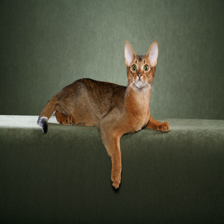

In [6]:
resize_image(oxford_pet_dataset["image_path"][0], 224)

In [7]:
def save_resize_oxford_pet_dataset(original_dataset):
    output_dir = "./data/resized_images"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index, row in original_dataset.iterrows():
        input_image_path = row["image_path"]
        resized_image = resize_image(input_image_path, 224)

        output_image_path = os.path.join(output_dir, row["image_name"])
        resized_image.save(output_image_path)

    return output_dir


resized_dataset_dir_path = save_resize_oxford_pet_dataset(oxford_pet_dataset)
resized_oxford_pet_dataset = read_images_dataset(resized_dataset_dir_path)
resized_oxford_pet_dataset.head(5)

### Split the dataset into trainval-test folds

This split is taken from [here](https://www.kaggle.com/datasets/julinmaloof/the-oxfordiiit-pet-dataset) and is the one recommended by the authors. Additionally, add the class information to each image.

In [11]:
resized_oxford_pet_dataset["image_name"] = resized_oxford_pet_dataset["image_name"].map(
    lambda x: x.replace(".jpg", "")
)
resized_oxford_pet_dataset = resized_oxford_pet_dataset.set_index("image_name")
resized_oxford_pet_dataset

,image_path,image_size
image_name,,
Abyssinian_1,./data/resized_images\Abyssinian_1.jpg,"(224, 224)"
Abyssinian_10,./data/resized_images\Abyssinian_10.jpg,"(224, 224)"
Abyssinian_100,./data/resized_images\Abyssinian_100.jpg,"(224, 224)"
Abyssinian_101,./data/resized_images\Abyssinian_101.jpg,"(224, 224)"
Abyssinian_102,./data/resized_images\Abyssinian_102.jpg,"(224, 224)"
...,...,...
yorkshire_terrier_95,./data/resized_images\yorkshire_terrier_95.jpg,"(224, 224)"
yorkshire_terrier_96,./data/resized_images\yorkshire_terrier_96.jpg,"(224, 224)"
yorkshire_terrier_97,./data/resized_images\yorkshire_terrier_97.jpg,"(224, 224)"


In [21]:
test_images = pd.read_csv("./data/test.txt", delimiter=" ", header=None)[[0, 1]]
test_images["fold"] = "test"

trainval_images = pd.read_csv("./data/trainval.txt", delimiter=" ", header=None)[[0, 1]]
trainval_images["fold"] = "trainval"

dataset_folds = (
    pd.concat([test_images, trainval_images])
    .rename({0: "image_name", 1: "class"}, axis=1)
    .set_index("image_name")
)
dataset_folds

,class,fold
image_name,,
Abyssinian_201,1,test
Abyssinian_202,1,test
Abyssinian_204,1,test
Abyssinian_205,1,test
Abyssinian_206,1,test
...,...,...
yorkshire_terrier_187,37,trainval
yorkshire_terrier_188,37,trainval
yorkshire_terrier_189,37,trainval


In [22]:
pet_dataset_info = resized_oxford_pet_dataset.join(dataset_folds, on="image_name")
pet_dataset_info = pet_dataset_info.dropna()
pet_dataset_info.to_csv("./data/pet_dataset_info.csv", index="image_name")
pet_dataset_info

,image_path,image_size,class,fold
image_name,,,,
Abyssinian_1,./data/resized_images\Abyssinian_1.jpg,"(224, 224)",1.0,trainval
Abyssinian_10,./data/resized_images\Abyssinian_10.jpg,"(224, 224)",1.0,trainval
Abyssinian_100,./data/resized_images\Abyssinian_100.jpg,"(224, 224)",1.0,trainval
Abyssinian_101,./data/resized_images\Abyssinian_101.jpg,"(224, 224)",1.0,trainval
Abyssinian_102,./data/resized_images\Abyssinian_102.jpg,"(224, 224)",1.0,trainval
...,...,...,...,...
yorkshire_terrier_95,./data/resized_images\yorkshire_terrier_95.jpg,"(224, 224)",37.0,test
yorkshire_terrier_96,./data/resized_images\yorkshire_terrier_96.jpg,"(224, 224)",37.0,test
yorkshire_terrier_97,./data/resized_images\yorkshire_terrier_97.jpg,"(224, 224)",37.0,test


## [QMUL-OpenLogo Dataset](https://hangsu0730.github.io/qmul-openlogo/)
We need to edit the images in this dataset by converting them to grayscale and applying a specified opacity.

In [ ]:
qmul_openlogo_dataset = read_images_dataset("./data/qmul_openlogo_dataset")
# shuffle the rows so that we can take a random subset

qmul_openlogo_dataset = qmul_openlogo_dataset.sample(frac=1, random_state=SEED).reset_index(
    drop=True
)

qmul_openlogo_dataset.head(5)

,image_name,image_path,image_size
0,nivea.jpg,./data/qmul_openlogo_dataset\nivea.jpg,"(300, 300)"
1,erdinger.jpg,./data/qmul_openlogo_dataset\erdinger.jpg,"(184, 173)"
2,bershka.jpg,./data/qmul_openlogo_dataset\bershka.jpg,"(228, 62)"
3,hsbc.jpg,./data/qmul_openlogo_dataset\hsbc.jpg,"(215, 111)"
4,disney.jpg,./data/qmul_openlogo_dataset\disney.jpg,"(316, 159)"


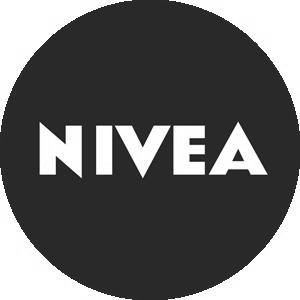

In [24]:
def convert_to_grayscale(image_path):
    image = Image.open(image_path)
    return image.convert("L")


convert_to_grayscale(qmul_openlogo_dataset["image_path"][0])

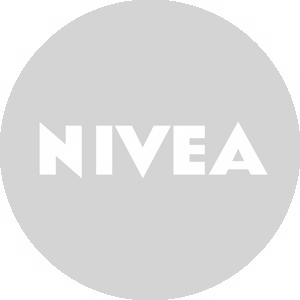

In [29]:
# Adjust the opacity value (0 to 1)
def change_opacity(image_path, opacity_value):
    opacity = int(opacity_value * 255)
    image = convert_to_grayscale(image_path)
    image = image.convert("RGBA")

    data = image.getdata()

    new_data = []
    for item in data:
        new_item = item[:3] + (opacity,)
        new_data.append(new_item)

    image.putdata(new_data)

    return image


change_opacity(qmul_openlogo_dataset["image_path"][0], 0.2)

## Creating the Final Dataset
Each logo will be applied on the host image at a random position with a random size, rotation and opacity. Considering the related work, each logo should be placed on multiple images and the logos included in the trainval and test sets should be disjoint. Because the dataset will be classified, we impose the constraint that each logo should be hosted by at least n images from each class. This will help in making sure the logos are distributed evenly across classes.

The settings used for placing watermarks:
- transparency: 35%-60% or 30%-70% or 60-85% or 35%-85%
- size: 60-85%
- rotation: 0%-45% in each direction


In [50]:
def get_logos(pet_dataset_info, qmul_openlogo_dataset, class_images_per_logo):
    classes_no = 37

    traival_logos_no = math.floor(
        pet_dataset_info[pet_dataset_info["fold"] == "trainval"].shape[0]
        / classes_no
        / class_images_per_logo
    )

    test_logos_no = math.floor(
        pet_dataset_info[pet_dataset_info["fold"] == "test"].shape[0]
        / classes_no
        / class_images_per_logo
    )

    trainval_logos = qmul_openlogo_dataset[:traival_logos_no]
    test_logos = qmul_openlogo_dataset[traival_logos_no : traival_logos_no + test_logos_no]

    return trainval_logos, test_logos


In [55]:
trainval_logos, test_logos = get_logos(pet_dataset_info, qmul_openlogo_dataset, 3)